In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly

from dimelo import plot_reads, load_processed

modkit found with expected version 0.2.4


# Reference plot

In [5]:
extract_file = Path('/Users/jeremy/devspace/dimelo_v2/dimelo/test/output/ctcf_demo_extract/reads.combined_basemods.h5')
extract_regions = Path('/Users/jeremy/devspace/dimelo_v2/dimelo/test/output/ctcf_demo_extract/regions.processed.bed')

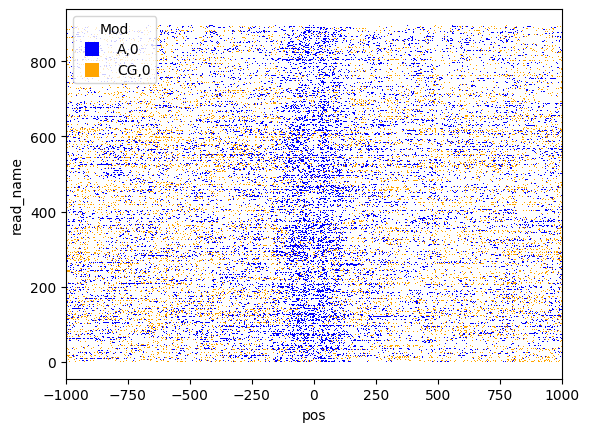

In [6]:
plot_reads.plot_reads(
    mod_file_name=extract_file,
    regions=extract_regions,
    motifs=['A,0', 'CG,0'],
    window_size=1000,
)
plt.show()

In [7]:
reads, read_names, mods, regions_dict = (
    load_processed.readwise_binary_modification_arrays(
        file=extract_file,
        regions=extract_regions,
        motifs=['A,0', 'CG,0'],
        window_size=1000,
        thresh=None,
        relative=True,
        sort_by="shuffle",
    )
)

In [8]:
df = pd.DataFrame({"read_name": read_names, "mod": mods, "pos": reads}).explode("pos")

In [9]:
df

,read_name,mod,pos
0,0,"A,0",-2135
1,0,"A,0",-2001
2,0,"A,0",-1638
3,0,"A,0",-1635
4,0,"A,0",-1632
...,...,...,...
108489,593,"A,0",464
108490,593,"A,0",645
108491,593,"A,0",847
108492,593,"A,0",849


/var/folders/l6/ylrj9klj2w53s9bbmvbq47rr0000gn/T/ipykernel_54565/3651502041.py:14: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


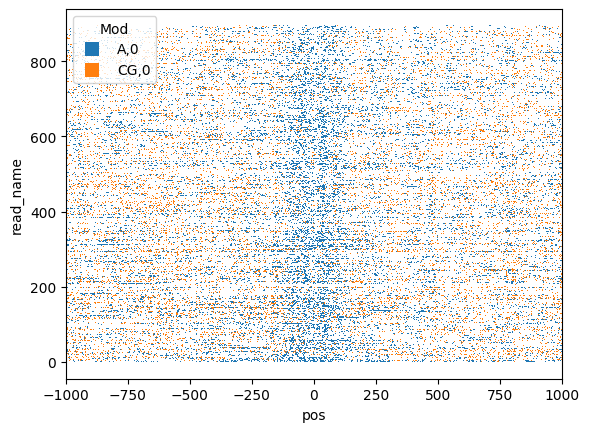

In [10]:
axes = sns.scatterplot(
    data=df,
    x="pos",
    y="read_name",
    hue="mod",
    # palette=colors,
    s=0.5,
    marker="s",
    linewidth=0
)
legend = axes.legend_
if legend is not None:
    legend.set_title("Mod")
    for handle in legend.legendHandles:
        if hasattr(handle, "set_markersize"):
            handle.set_markersize(10)  # Set a larger marker size for legend
# For relative
region1_start, region1_end, _ = next(iter(regions_dict.values()))[0]
effective_window_size = (region1_end - region1_start) // 2
axes.set_xlim([-effective_window_size, effective_window_size])
plt.show()

# Straight up minimal port

In [34]:
DEFAULT_THRESH_A = 129
DEFAULT_THRESH_C = 129
DEFAULT_DOTSIZE = 4
COLOR_A = "#053C5E"
COLOR_C = "#BB4430"

In [31]:
class DataTraces(object):
    def __init__(self, traces, names):
        self.traces = traces
        self.names = names
        self.index = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.index == len(self.traces):
            raise StopIteration
        else:
            self.index += 1
            return self.traces[self.index - 1]

In [32]:
def find_min_and_max_pos_per_read(table):
    """Return a table with for every read the minimum and maximum position"""
    mm_table = (
        table.loc[:, ["read_name", "pos"]]
        .groupby("read_name")
        .min()
        .join(
            table.loc[:, ["read_name", "pos"]].groupby("read_name").max(),
            lsuffix="min",
            rsuffix="max",
        )
    )
    return mm_table

In [33]:
def assign_y_height_per_read(df, max_coverage=1000):
    """Assign height of the read in the per read traces
    Gets a dataframe of read_name, posmin and posmax.
    Sorting by position.
    Determines optimal height (y coordinate) for this read
    Returns a dictionary mapping read_name to y_coord
    """
    dfs = df.sort_values(by=["posmin", "posmax"], ascending=[True, False])
    heights = [[] for i in range(max_coverage)]
    y_pos = dict()
    for read in dfs.itertuples():
        for y, layer in enumerate(heights, start=1):
            if len(layer) == 0:
                layer.append(read.posmax)
                y_pos[read.Index] = y
                break
            if read.posmin > layer[-1]:
                layer.append(read.posmax)
                y_pos[read.Index] = y
                break
    return pd.DataFrame(
        {"read": list(y_pos.keys()), "height": list(y_pos.values())}
    ).set_index("read")

In [34]:
def make_per_read_line_trace(read_range, y_pos):
    """
    Make a grey line trace for a single read
    """
    return plotly.go.Scatter(
        x=[read_range["posmin"], read_range["posmax"]],
        y=[y_pos, y_pos],
        mode="lines",
        line=dict(width=1, color="lightgrey"),
        showlegend=False,
    )

In [35]:
def make_per_position_phred_scatter(
    all_data, read_table, mod, thresh, dotsize=DEFAULT_DOTSIZE, colorscale="Reds", offset=0
):
    """Make scatter plot per modified base per read"""
    # get min and max probabilities across all for legend and color consistency for comparisons
    if "C" in mod:
        m = "C"
    if "A" in mod:
        m = "A"
    min_overall = 255
    max_overall = 0
    for d in all_data:
        min_temp = d[(d["mod"].str.contains(m)) & (d["prob"] >= thresh)][
            "prob"
        ].min()
        max_temp = d[(d["mod"].str.contains(m)) & (d["prob"] >= thresh)][
            "prob"
        ].max()
        if min_temp < min_overall:
            min_overall = min_temp
        if max_temp > max_overall:
            max_overall = max_temp
    return plotly.go.Scatter(
        x=read_table["pos"],
        y=read_table["height"],
        mode="markers",
        showlegend=False,
        text=round(read_table["prob"] / 255, 2),
        hoverinfo="text",
        marker=dict(
            size=dotsize,
            color=read_table["prob"],
            colorscale=colorscale,
            colorbar=dict(
                title=mod + " probability",
                titleside="right",
                tickmode="array",
                tickvals=[min_overall, max_overall],
                ticktext=[
                    str(round(min_overall / 255, 2)),
                    str(round(max_overall / 255, 2)),
                ],
                ticks="outside",
                thickness=15,
                x=offset + 1,
            ),
        ),
    )

In [36]:
def make_per_read_meth_traces_phred(
    all_data,
    table,
    basemod,
    colorA,
    colorC,
    max_cov=1000,
    dotsize=DEFAULT_DOTSIZE,
    threshA=DEFAULT_THRESH_A,
    threshC=DEFAULT_THRESH_C,
):
    """Make traces for each read"""
    minmax_table = find_min_and_max_pos_per_read(table)
    df_heights = assign_y_height_per_read(minmax_table, max_coverage=max_cov)
    table = pd.merge(table, df_heights, left_on="read_name", right_on="read")
    traces = []
    hidden = 0
    for read in table["read_name"].unique():
        try:
            traces.append(
                make_per_read_line_trace(
                    read_range=minmax_table.loc[read],
                    y_pos=df_heights.loc[read, "height"],
                )
            )
        except KeyError:
            hidden += 1
            continue
    if hidden:
        sys.stderr.write(
            f"Warning: hiding {hidden} reads because coverage above {max_cov}x.\n"
        )
    read_table_mC = table[table["mod"].str.contains("C")]
    read_table_mA = table[table["mod"].str.contains("A")]
    cmapA = ["white", colorA]
    cmapC = ["white", colorC]
    if "C" in basemod:
        traces.append(
            make_per_position_phred_scatter(
                all_data=all_data,
                read_table=read_table_mC[read_table_mC["prob"] >= threshC],
                mod="mC",
                thresh=threshC,
                dotsize=dotsize,
                colorscale=cmapC,
                offset=0.05,
            )
        )
    if "A" in basemod:
        traces.append(
            make_per_position_phred_scatter(
                all_data=all_data,
                read_table=read_table_mA[read_table_mA["prob"] >= threshA],
                mod="mA",
                thresh=threshA,
                dotsize=dotsize,
                colorscale=cmapA,
                offset=0.15,
            )
        )
    return traces

In [37]:
def methylation(
    all_data,
    sampleNames,
    basemod,
    colorA=COLOR_A,
    colorC=COLOR_C,
    dotsize=DEFAULT_DOTSIZE,
    threshA=DEFAULT_THRESH_A,
    threshC=DEFAULT_THRESH_C,
):
    """
    Plot methylation traces
    """
    traces = []
    names = []
    for m, n in zip(all_data, sampleNames):
        traces.append(
            make_per_read_meth_traces_phred(
                all_data=all_data,
                table=m,
                basemod=basemod,
                colorA=colorA,
                colorC=colorC,
                dotsize=dotsize,
                threshA=threshA,
                threshC=threshC,
            )
        )
        names.append(n)
    return DataTraces(traces=traces, names=names)

In [38]:
def create_subplots(num_methrows, names=None, annotation=True):
    """
    Prepare the panels (rows * 1 column) for the subplots.
    One row for each dataset, taking 90%/len(datasets) for heights
    if annotation is True (bed) then add a row with height 10%
    """
    return plotly.subplots.make_subplots(
        rows=num_methrows + annotation,
        cols=1,
        shared_xaxes=True,
        specs=[[{}] for i in range(num_methrows + annotation)],
        print_grid=False,
        subplot_titles=names,
        vertical_spacing=0.1 if num_methrows < 10 else 0.01,
        row_heights=[0.9 / num_methrows] * num_methrows + [0.1] * annotation,
    )

In [ ]:
# TODO: Don't understand enough of what this is doing, nor what it's being used for (bed annotation?)
# def parse_bed(bed, region):
#     gr = pr.read_bed(bed)[region.chromosome, region.begin : region.end]
#     df = gr.unstrand().df
#     df = df.drop(columns=["Chromosome", "Score", "Strand"], errors="ignore")
#     if "Name" not in df.columns:
#         df["Name"] = "noname"
#     df_short = df[df.columns[0:3]]
#     return df_short.itertuples(index=False, name=None)

In [ ]:
# TODO: Don't understand enough of what this is doing, nor what it's being used for (bed annotation?)
# def bed_annotation(bed, region):
#     return [
#         plotly.go.Scatter(
#             x=[begin, end],
#             y=[-2, -2],
#             mode="lines",
#             line=dict(width=16, color="grey"),
#             text=name,
#             hoverinfo="text",
#             showlegend=False,
#         )
#         for (begin, end, name) in parse_bed(bed, region)
#     ]

In [39]:
def create_output(fig, outfile, region, static, outDir):
    """
    write output pdf or html
    """
    if static:
        outfile = outDir + "/" + f"methylation_browser_{region.string}.pdf"
        fig.write_image(outfile, width=1000, height=400)
    if not static:
        outfile = outDir + "/" + f"methylation_browser_{region.string}.html"
        with open(outfile, "w+") as output:
            output.write(
                plotly.offline.plot(
                    fig,
                    output_type="div",
                    show_link=False,
                    include_plotlyjs="cdn",
                )
            )

In [40]:
# TODO: Pretty sure outfile is totally useless and just overwritten in create_output()
def meth_browser(
    all_data,
    basemod,
    region,
    sampleNames,
    outDir,
    bed=False,
    outfile=None,
    dotsize=DEFAULT_DOTSIZE,
    static=False,
    threshA=DEFAULT_THRESH_A,
    threshC=DEFAULT_THRESH_C,
    colorA=COLOR_A,
    colorC=COLOR_C,
):
    """
    meth_data is a list of methylationByBase tables as dataframes
    all_dict is a list of methylationAggregate tables as dataframes
    annotation is optional and is a bed file
     then show one line per sample and one for the annotation, with methrows = number of datasets
    the trace to be used for annotation is thus always num_methrows + 1
    """
    meth_traces = methylation(
        all_data,
        sampleNames,
        basemod,
        colorA=colorA,
        colorC=colorC,
        dotsize=dotsize,
        threshA=threshA,
        threshC=threshC,
    )

    num_methrows = len(all_data)
    annot_row = num_methrows + 1
    annot_axis = f"yaxis{annot_row}"
    fig = create_subplots(
        num_methrows, names=meth_traces.names, annotation=bool(bed)
    )
    for y, sample_traces in enumerate(meth_traces, start=1):
        for meth_trace in sample_traces:
            fig.add_trace(trace=meth_trace, row=y, col=1)
        fig["layout"][f"yaxis{y}"].update(title="Reads")
    # TODO: Don't understand enough of what this is doing, nor what it's being used for (bed annotation?)
    # if bed:
    #     for annot_trace in bed_annotation(bed, region):
    #         fig.add_trace(trace=annot_trace, row=annot_row, col=1)
    #     y_max = -2
    # if bed:
    #     fig["layout"][annot_axis].update(
    #         range=[-2, y_max + 1],
    #         showgrid=False,
    #         zeroline=False,
    #         showline=False,
    #         ticks="",
    #         showticklabels=False,
    #     )
    fig["layout"]["xaxis"].update(
        tickformat="g",
        separatethousands=True,
        range=[region.begin, region.end],
    )
    fig["layout"].update(
        barmode="overlay",
        title=region.chromosome,
        hovermode="closest",
        plot_bgcolor="rgba(0,0,0,0)",
    )
    if num_methrows > 10:
        for i in fig["layout"]["annotations"]:
            i["font"]["size"] = 10
    create_output(fig, outfile, region, static, outDir)

In [ ]:
region_str = 'chr14:17376348-17382284'

In [ ]:
# TODO: I think this is accurate...?
# all_data is a list of methylationByBase tables as dataframes

In [ ]:
# meth_browser(
#     all_data=,
#     basemod='A+CG',
#     region=region_str,
#     sampleNames='TEST',
#     outDir='.',
#     # bed=False,
#     outfile=None,
#     # dotsize=DEFAULT_DOTSIZE,
#     static=True,
#     # threshA=DEFAULT_THRESH_A,
#     # threshC=DEFAULT_THRESH_C,
#     # colorA=COLOR_A,
#     # colorC=COLOR_C,
# )

# Rebuilding testing 1

In [1]:
from pathlib import Path

import pandas as pd
import plotly

from dimelo import load_processed

modkit found with expected version 0.2.4


In [9]:
DEFAULT_THRESH_A = 129
DEFAULT_THRESH_C = 129
DEFAULT_DOTSIZE = 4
COLOR_A = "#053C5E"
COLOR_C = "#BB4430"

In [2]:
extract_file = Path('/Users/jeremy/devspace/dimelo_v2/dimelo/test/output/ctcf_demo_extract/reads.combined_basemods.h5')
extract_regions = Path('/Users/jeremy/devspace/dimelo_v2/dimelo/test/output/ctcf_demo_extract/regions.processed.bed')

In [25]:
reads, read_names, mods, regions_dict = (
    load_processed.readwise_binary_modification_arrays(
        file=extract_file,
        regions=extract_regions,
        motifs=['A,0', 'CG,0'],
        # window_size=1000,
        thresh=None,
        relative=False,
    )
)

In [26]:
df = pd.DataFrame({"read_name": read_names, "mod": mods, "pos": reads}).explode("pos")

In [27]:
test_df = df[df.read_name.isin([0,   1,   2,   3,   4,   5,   6,   7,   9,  11])]

In [28]:
test_df

,read_name,mod,pos
0,0,"A,0",9169133
1,0,"A,0",9169533
2,0,"A,0",9169599
3,0,"A,0",9169600
4,0,"A,0",9169806
...,...,...,...
4840,11,"CG,0",9168260
4841,11,"CG,0",9168287
4842,11,"CG,0",9168444
4843,11,"CG,0",9168633


In [32]:
fig = plotly.graph_objects.Figure()
for y_idx, read_df in test_df.groupby('read_name'):
    # Draw a grey line to act as the background of the read (wrong because don't have actual start and end coords yet, just pos of first and last mod)
    fig.add_trace(
        plotly.graph_objects.Scatter(
            x=[read_df.pos.min(), read_df.pos.max()],
            y=[y_idx, y_idx],
            mode="lines",
            line=dict(width=1, color="lightgrey"),
            showlegend=False,
        )
    )
    # Draw a dot for each mod (although every mod is currently colored the same...)
    fig.add_trace(
        plotly.graph_objects.Scatter(
            x=read_df["pos"],
            y=[y_idx] * len(read_df["pos"]),
            mode="markers",
            showlegend=False,
            # text=round(read_table["prob"] / 255, 2),
            hoverinfo="text",
            marker=dict(
                size=DEFAULT_DOTSIZE,
                # color=read_table["prob"],
                # colorscale="Reds",
                colorbar=dict(
                    # title=mod + " probability",
                    titleside="right",
                    tickmode="array",
                    # tickvals=[min_overall, max_overall],
                    # ticktext=[
                        # str(round(min_overall / 255, 2)),
                        # str(round(max_overall / 255, 2)),
                    # ],
                    ticks="outside",
                    thickness=15,
                    # x=offset + 1,
                ),
            ),
        )
    )
fig.update_layout(
    barmode="overlay",
    title="test_title",
    hovermode="closest",
    plot_bgcolor="rgba(0,0,0,0)",
)
fig.show()

# Extracting test reads

In [142]:
from pathlib import Path

from dimelo import parse_bam

In [143]:
output_dir = Path('./dimelo/test/output')
output_dir.mkdir(exist_ok=True)

ctcf_bam_file_updated = output_dir / 'ctcf_demo.updated.bam'
ref_genome_file = output_dir / 'chm13.draft_v1.0.fasta'

test_data_dir = Path('./dimelo/test/data')

# ctcf_target_regions = test_data_dir / 'ctcf_demo_peak.bed'
ctcf_target_regions = 'chr11:2086423-2091187'

In [144]:
extract_file, extract_regions = parse_bam.extract(
    input_file=ctcf_bam_file_updated,
    output_name='browser_test',
    ref_genome=ref_genome_file,
    output_directory=output_dir,
    regions=ctcf_target_regions,
    motifs=['A,0','CG,0'],
    # thresh=190,
    # window_size=1000,
)

No specified number of cores requested. 10 available on machine, allocating all.
No valid base modification threshold provided. Raw probs will be saved.


          | Preprocessing   0% | 00:00

          | Processing ctcf_demo.updated.bam   0% | 00:00<?

          |    0%

          | Transferring 61 from reads.A,0.txt into reads.combined_basemods.h5, new size 61   0% | 00:00<?

          | Preprocessing   0% | 00:00

          | Processing ctcf_demo.updated.bam   0% | 00:00<?

          |    0%

          | Transferring 61 from reads.CG,0.txt into reads.combined_basemods.h5, new size 122   0% | 00:00<?

In [145]:
print(extract_file)
print(extract_regions)

dimelo/test/output/browser_test/reads.combined_basemods.h5
dimelo/test/output/browser_test/regions.processed.bed


# Rebuilding testing 2

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import plotly

from dimelo import load_processed

modkit found with expected version 0.2.4


In [2]:
DEFAULT_THRESH_A = 129
DEFAULT_THRESH_C = 129
DEFAULT_DOTSIZE = 4
COLOR_A = "#053C5E"
COLOR_C = "#BB4430"

In [3]:
region_str = 'chr11:2086423-2091187'

In [4]:
extract_file = Path('/Users/jeremy/devspace/dimelo_v2/dimelo/test/output/browser_test/reads.combined_basemods.h5')
extract_regions = Path('/Users/jeremy/devspace/dimelo_v2/dimelo/test/output/browser_test/regions.processed.bed')

In [5]:
"""
Notes and thoughts about this method:
    * The name is confusing. Doesn't actually return vectors, does it...? I mean, I guess it does. Eugh. IDK
    * What is the region_dict for? Seems as if it's useless to me...? Redundant with the read tuples?
    * Maybe let's put it this way: why not have the return structure look like the one for pileups? (e.g. different vectors that are easy to work with)
      * Could even be autogenerated as properties of a return structure class, if we're worried about storage, but I don't know if that's actually necessary
    * I have had to reference parse_bam in order to attempt to understand the contents of the returned entries. If this is intended, there needs to be a reference instructing users to do so in order to understand the returns. Or the returns need to be explained fully. Or be bespoke object types.
      * EXCEPT THAT DIDN'T HELP EITHER...
    * coord 0 corresponds to read_start
    * coord -1 corresponds to the final valid pos
    * means that the A and CpG vectors should be of different lengths
    Returns:
        a list of tuples, each tuple containing all datasets corresponding to an individual read that
        was within the specified regions.
        a list of strings, naming the datasets returned.
        a regions_dict, containing lists of (region_start,region_end) coordinates by chromosome/contig.
"""
read_tuples, entry_labels, _ = (
    load_processed.read_vectors_from_hdf5(
        file=extract_file,
        regions=region_str,
        motifs=['A,0', 'CG,0'],
        calculate_mod_fractions=False
    )
)

In [6]:
for i in range(1):
    print(f'entry {i}')
    for k, v in zip(entry_labels, read_tuples[i]):
        print(f'\t{k}: {v}')

entry 0
	chromosome: chr11
	mod_vector: [0.       0.       0.       ... 0.       0.       0.001953]
	motif: A,0
	read_end: 2105631
	read_name: 329fd68b-5c1a-4790-98fe-9b998d972750
	read_start: 2020326
	strand: -
	val_vector: [0 0 0 ... 0 0 1]
	region_start: 2086423
	region_end: 2091187


In [7]:
# Coerce read tuples to initial dataframe, throwing away unnecessary columns
to_exclude = ['chromosome', 'strand', 'region_start', 'region_end']
read_df = pd.DataFrame.from_records(read_tuples, columns=entry_labels, exclude=to_exclude)
read_df

,mod_vector,motif,read_end,read_name,read_start,val_vector
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","A,0",2105631,329fd68b-5c1a-4790-98fe-9b998d972750,2020326,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","CG,0",2105631,329fd68b-5c1a-4790-98fe-9b998d972750,2020326,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","A,0",2089538,27c8204f-d640-4679-9bfc-d97e812d842a,2026502,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","CG,0",2089538,27c8204f-d640-4679-9bfc-d97e812d842a,2026502,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","A,0",2087444,475c4400-f536-42d0-832d-52642701e436,2049588,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
117,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","CG,0",2097221,5b89e981-c791-43b8-9c87-1a3ed7c58ebf,2090880,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
118,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","A,0",2112409,ce3752fc-b5c7-47e9-bc97-a91f27fad95c,2091060,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
119,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","CG,0",2112409,ce3752fc-b5c7-47e9-bc97-a91f27fad95c,2091060,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
120,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001953, ...","A,0",2117335,f1576643-4288-4205-ab0c-e7b07dc6be11,2091139,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, ..."


In [8]:
# TODO: I don't like using iterrows, but it seems silly to have two calls to apply that do basically the same thing redundantly; just looping once instead
# For each row, pull out just the positions of valid bases and the probabilities at those positions
prob_vectors = []
pos_vectors = []
for _, row in read_df.iterrows():
    selector = row.val_vector == 1
    all_positions = np.arange(len(row.mod_vector)) + row.read_start

    prob_vectors.append(row.mod_vector[selector])
    pos_vectors.append(all_positions[selector])
read_df['prob_vector'] = prob_vectors
read_df['pos_vector'] = pos_vectors

In [9]:
read_df

,mod_vector,motif,read_end,read_name,read_start,val_vector,prob_vector,pos_vector
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","A,0",2105631,329fd68b-5c1a-4790-98fe-9b998d972750,2020326,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.001953, 0.001953, 0.001953, 0.001953, 0.001...","[2086425, 2086426, 2086433, 2086438, 2086453, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","CG,0",2105631,329fd68b-5c1a-4790-98fe-9b998d972750,2020326,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.001953, 0.001953, 0.001953, 0.001953, 0.001...","[2086430, 2086476, 2086478, 2086484, 2086513, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","A,0",2089538,27c8204f-d640-4679-9bfc-d97e812d842a,2026502,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.001953, 0.001953, 0.001953, 0.01367, 0.0683...","[2086425, 2086426, 2086433, 2086438, 2086453, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","CG,0",2089538,27c8204f-d640-4679-9bfc-d97e812d842a,2026502,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.001953, 0.1426, 0.01367, 0.001953, 0.5215, ...","[2086430, 2086476, 2086478, 2086484, 2086513, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","A,0",2087444,475c4400-f536-42d0-832d-52642701e436,2049588,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.001953, 0.338, 0.001953, 0.001953, 0.00586,...","[2086423, 2086428, 2086436, 2086437, 2086440, ..."
...,...,...,...,...,...,...,...,...
117,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","CG,0",2097221,5b89e981-c791-43b8-9c87-1a3ed7c58ebf,2090880,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.12305, 0.11523, 0.8457, 0.001953, 0.2988]","[2091006, 2091104, 2091128, 2091158, 2091186]"
118,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","A,0",2112409,ce3752fc-b5c7-47e9-bc97-a91f27fad95c,2091060,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[0.001953, 0.001953, 0.001953, 0.4863, 0.2246,...","[2091071, 2091073, 2091075, 2091081, 2091092, ..."
119,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","CG,0",2112409,ce3752fc-b5c7-47e9-bc97-a91f27fad95c,2091060,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0371, 0.0293, 0.001953, 0.001953]","[2091104, 2091128, 2091158, 2091186]"
120,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001953, ...","A,0",2117335,f1576643-4288-4205-ab0c-e7b07dc6be11,2091139,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, ...","[0.001953, 0.001953, 0.001953, 0.001953, 0.001...","[2091146, 2091149, 2091152, 2091162, 2091164, ..."


In [10]:
# TODO: I'm pretty sure that however I do this, there will possibly be an "overdrawing" problem if the same read shows up multiple times. Do I care? Will it be taken care of by dropping duplicates?
# TODO: There is probably a better way to do this. I investigated pd.Categorical, but couldn't figure out how to tell it to do it in the passed order.
# TODO: This downcasting warning is INCREDIBLY vague, and I can't tell if it's actually a problem in this case. I even tried following their instructions and it didn't fix anything. UGHHHHHHHHHH...
# assign reads y-axis values based on their unique names, preserving the pre-set order
read_df['y_index'] = read_df.read_name.replace({k: v for v, k in enumerate(read_df.read_name.unique())})

/var/folders/l6/ylrj9klj2w53s9bbmvbq47rr0000gn/T/ipykernel_6012/3752108334.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  read_df['y_index'] = read_df.read_name.replace({k: v for v, k in enumerate(read_df.read_name.unique())})


In [11]:
read_df

,mod_vector,motif,read_end,read_name,read_start,val_vector,prob_vector,pos_vector,y_index
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","A,0",2105631,329fd68b-5c1a-4790-98fe-9b998d972750,2020326,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.001953, 0.001953, 0.001953, 0.001953, 0.001...","[2086425, 2086426, 2086433, 2086438, 2086453, ...",0
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","CG,0",2105631,329fd68b-5c1a-4790-98fe-9b998d972750,2020326,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.001953, 0.001953, 0.001953, 0.001953, 0.001...","[2086430, 2086476, 2086478, 2086484, 2086513, ...",0
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","A,0",2089538,27c8204f-d640-4679-9bfc-d97e812d842a,2026502,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.001953, 0.001953, 0.001953, 0.01367, 0.0683...","[2086425, 2086426, 2086433, 2086438, 2086453, ...",1
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","CG,0",2089538,27c8204f-d640-4679-9bfc-d97e812d842a,2026502,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.001953, 0.1426, 0.01367, 0.001953, 0.5215, ...","[2086430, 2086476, 2086478, 2086484, 2086513, ...",1
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","A,0",2087444,475c4400-f536-42d0-832d-52642701e436,2049588,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.001953, 0.338, 0.001953, 0.001953, 0.00586,...","[2086423, 2086428, 2086436, 2086437, 2086440, ...",2
...,...,...,...,...,...,...,...,...,...
117,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","CG,0",2097221,5b89e981-c791-43b8-9c87-1a3ed7c58ebf,2090880,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.12305, 0.11523, 0.8457, 0.001953, 0.2988]","[2091006, 2091104, 2091128, 2091158, 2091186]",58
118,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","A,0",2112409,ce3752fc-b5c7-47e9-bc97-a91f27fad95c,2091060,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[0.001953, 0.001953, 0.001953, 0.4863, 0.2246,...","[2091071, 2091073, 2091075, 2091081, 2091092, ...",59
119,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","CG,0",2112409,ce3752fc-b5c7-47e9-bc97-a91f27fad95c,2091060,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0371, 0.0293, 0.001953, 0.001953]","[2091104, 2091128, 2091158, 2091186]",59
120,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001953, ...","A,0",2117335,f1576643-4288-4205-ab0c-e7b07dc6be11,2091139,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, ...","[0.001953, 0.001953, 0.001953, 0.001953, 0.001...","[2091146, 2091149, 2091152, 2091162, 2091164, ...",60


In [12]:
# TODO: Dropping duplicates should hide the "overdrawing" problem when reads are duplicated in the dataset. Is this a problem or the intended behavior?
# Get two separate dataframes:
# * represents the read extents, to draw the grey lines
read_extent_df = read_df[['read_start', 'read_end', 'y_index']].drop_duplicates()
# * represents the methylation events
mod_event_df = read_df[['y_index', 'motif', 'pos_vector', 'prob_vector']].explode(['pos_vector', 'prob_vector']).rename(columns={'pos_vector': 'pos', 'prob_vector': 'prob'})

In [13]:
read_extent_df

,read_start,read_end,y_index
0,2020326,2105631,0
2,2026502,2089538,1
4,2049588,2087444,2
6,2052742,2088056,3
8,2057567,2090127,4
...,...,...,...
112,2090405,2099149,56
114,2090462,2095121,57
116,2090880,2097221,58
118,2091060,2112409,59


In [14]:
mod_event_df

,y_index,motif,pos,prob
0,0,"A,0",2086425,0.001953
0,0,"A,0",2086426,0.001953
0,0,"A,0",2086433,0.001953
0,0,"A,0",2086438,0.001953
0,0,"A,0",2086453,0.001953
...,...,...,...,...
120,60,"A,0",2091173,0.001953
120,60,"A,0",2091175,0.001953
120,60,"A,0",2091176,0.001953
120,60,"A,0",2091185,0.001953


In [15]:
# TODO: I know there's an off by a little bit error here, but I don't care to fix it yet
# Apply threshold to mod_event_df
# mod_event_df.drop(mod_eve)
thresh_float = DEFAULT_THRESH_A / 255
mod_event_df = mod_event_df[mod_event_df.prob > thresh_float]

In [16]:
mod_event_df

,y_index,motif,pos,prob
0,0,"A,0",2086712,0.732422
0,0,"A,0",2086730,0.658203
0,0,"A,0",2086764,0.798828
0,0,"A,0",2086765,0.826172
0,0,"A,0",2086767,0.759766
...,...,...,...,...
114,57,"A,0",2090688,0.826172
114,57,"A,0",2090719,0.533203
114,57,"A,0",2090724,0.791016
114,57,"A,0",2090747,0.759766


In [17]:
# TODO: I feel like there has to be a cleaner way to do this, maybe using plotly express, but I dont know and I'm just trying to get this done first. Lots of iterrows. Sad.
fig = plotly.graph_objects.Figure()
for _, row in read_extent_df.iterrows():
        fig.add_trace(
            plotly.graph_objects.Scatter(
                x=[row.read_start, row.read_end],
                y=[row.y_index, row.y_index],
                mode="lines",
                line=dict(width=1, color="lightgrey"),
                showlegend=False,
            )
        )
# TODO: This way of specifying color is very dumb.
color_specs = [
      ['white', COLOR_A],
      ['white', COLOR_C]
]
for motif_idx, (motif, motif_df) in enumerate(mod_event_df.groupby('motif')):
    min_overall = motif_df['prob'].min()
    max_overall = motif_df['prob'].max()
    fig.add_trace(
            plotly.graph_objs.Scatter(
                x=motif_df['pos'],
                y=motif_df['y_index'],
                mode="markers",
                showlegend=False,
                marker=dict(
                    size=DEFAULT_DOTSIZE,
                    color=motif_df['prob'],
                    # TODO: This way of specifying color is very dumb.
                    colorscale=color_specs[motif_idx],
                    colorbar=dict(
                        title=f'{motif} probability',
                        titleside='right',
                        tickmode='array',
                        tickvals=[min_overall, max_overall],
                        ticktext=[
                            str(round(min_overall, 2)),
                            str(round(max_overall, 2)),
                        ],
                        ticks="outside",
                        thickness=15,
                        # TODO: Is this positioning system dumb?
                        x=1+(motif_idx * 0.10),
                    ),
                ),
            )
    )
#     # Draw a dot for each mod (although every mod is currently colored the same...)
#     fig.add_trace(
#         plotly.graph_objects.Scatter(
#             x=read_df["pos"],
#             y=[y_idx] * len(read_df["pos"]),
#             mode="markers",
#             showlegend=False,
#             # text=round(read_table["prob"] / 255, 2),
#             hoverinfo="text",
#             marker=dict(
#                 size=DEFAULT_DOTSIZE,
#                 # color=read_table["prob"],
#                 # colorscale="Reds",
#                 colorbar=dict(
#                     # title=mod + " probability",
#                     titleside="right",
#                     tickmode="array",
#                     # tickvals=[min_overall, max_overall],
#                     # ticktext=[
#                         # str(round(min_overall / 255, 2)),
#                         # str(round(max_overall / 255, 2)),
#                     # ],
#                     ticks="outside",
#                     thickness=15,
#                     # x=offset + 1,
#                 ),
#             ),
#         )
#     )
fig.update_layout(
    barmode="overlay",
    title="test_title",
    hovermode="closest",
    plot_bgcolor="rgba(0,0,0,0)",
)
fig.show()

In [19]:
output_dir = Path('.')
output_basename = 'browser_demo'

In [21]:
# TODO: Need to add kaleido for image export: pip install kaleido
# TODO: Are these good dimensions? It annoys me that they are hard-coded
# testing static output
static_formats = ['pdf', 'png', 'svg']
for f in static_formats:
    fig.write_image(output_dir / f'{output_basename}.{f}', width=1000, height=400)

In [23]:
# test html output
with open(output_dir / f"{output_basename}_original.html", "w") as output:
    output.write(
        plotly.offline.plot(
            fig,
            output_type="div",
            show_link=False,
            include_plotlyjs="cdn",
        )
    )

fig.write_html(output_dir / f"{output_basename}.html", include_plotlyjs="cdn")